In [ ]:
### Install Environment
!pip install timm
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 102 kB/s 


In [ ]:
!gdown --id 1ydH-yxL9341xLCe6GE1rw1SmoN_jpctO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ydH-yxL9341xLCe6GE1rw1SmoN_jpctO
To: /content/drive/MyDrive/AIChangellen/data.zip
100% 1.94G/1.94G [00:15<00:00, 127MB/s]


In [ ]:
!unzip data.zip

In [ ]:
import numpy as np 
import pandas as pd 

import os 
import cv2 
import warnings
import timm 

from torchvision import transforms

import torch 
import torch.nn.functional as F 
from torch import nn 
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

from torch.utils.data import Dataset

import math

from tqdm.notebook import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [ ]:
def img_path_from_id(id):
    split_id = id.split("_")
    sub_folder = "_".join(split_id[:-1])
    img_path = os.path.join('data', 'train',
                            sub_folder, f'{id}.jpg')
    return img_path


class LmkRetrDataset(Dataset):
    def __init__(self, file_name):
        self.df = pd.read_csv(os.path.join("data", "train", file_name), header=0)
        self.landmark_id_encoder = preprocessing.LabelEncoder()
        self.df['landmark_id'] = self.landmark_id_encoder.fit_transform(
            self.df['landmark_id'])
        self.df['path'] = self.df['id'].apply(img_path_from_id)
        self.paths = self.df['path'].values
        self.ids = self.df['id'].values
        self.landmark_ids = self.df['landmark_id'].values

    def __len__(self):
        return len(self.df)
      
    def __getitem__(self, idx):
        path, id, landmark_id = self.paths[idx], self.ids[idx], self.landmark_ids[idx]

        try:  
          img = cv2.imread(path)
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          
          MEAN = [0.485, 0.456, 0.406]
          STD = [0.229, 0.224, 0.225]

          transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((768, 768)),
              transforms.ToTensor(),
              transforms.Normalize(MEAN, STD),
          ])

          img = transform(img)
        except Exception as e:
          print("image error: ", path)
          assert "error"

        return {
            'image' : img,
            'label' : torch.tensor(landmark_id)
        }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class ModelIRScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ModelIRScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [ ]:
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
 
        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)
                
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [ ]:
''' I just wanted to understand and implement custom backward activation in PyTorch so I choose this.
    You can also simply use this function below too.

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return input * (torch.tanh(F.softplus(input)))
'''

class Mish_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 

class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        print("Mish initialized")
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [ ]:
def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [ ]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

In [ ]:
class IRModel(nn.Module):
  
    def __init__(self, n_classes = 17, model_name = 'resnext50_32x4d', fc_dim = 512,
                  margin = 0.5, scale = 30, use_fc = True, pretrained = True):
        super(IRModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split

with open("data/train/train_list.txt") as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    lines = lines[1:1001] #Test with 1000 image

In [ ]:
train_list, val_list = train_test_split(lines, test_size=0.2, random_state=42, shuffle=True)

print("len(train_list): ", len(train_list))
print("len(val_list): ", len(val_list))

len(train_list):  800
len(val_list):  200


In [ ]:
if os.path.exists("data/train/train.txt"):
  os.remove("data/train/train.txt")
with open("data/train/train.txt", "a+") as ft:
  ft.write("id,landmark_id\n")
  for line in train_list:
    ft.write("{}\n".format(line))

In [ ]:
if os.path.exists("data/train/val.txt"):
  os.remove("data/train/val.txt")
with open("data/train/val.txt", "a+") as fv:
  fv.write("id,landmark_id\n")
  for line in val_list:
    fv.write("{}\n".format(line))

In [ ]:
transformed_train_data = LmkRetrDataset('train.txt')
transformed_val_data = LmkRetrDataset('val.txt')

In [ ]:
train_data_loader = torch.utils.data.DataLoader(transformed_train_data, batch_size=8, shuffle=True, num_workers=1)
val_data_loader = torch.utils.data.DataLoader(transformed_val_data, batch_size=8, shuffle=False, num_workers=1)

In [ ]:
model = IRModel()
model.to(device)

Building Model Backbone for resnext50_32x4d model


IRModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

In [ ]:
existing_layer = torch.nn.SiLU
new_layer = Mish()
model = replace_activations(model, existing_layer, new_layer)

Mish initialized


In [ ]:
SCHEDULER_PARAMS = {
            "lr_start": 1e-5,
            "lr_max": 1e-5 * 32,
            "lr_min": 1e-6,
            "lr_ramp_ep": 5,
            "lr_sus_ep": 0,
            "lr_decay": 0.8,
        }

optimizer = Ranger(model.parameters(), lr = SCHEDULER_PARAMS['lr_start'])
scheduler = ModelIRScheduler(optimizer,**SCHEDULER_PARAMS)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [ ]:
def train_fn(model, data_loader, optimizer, scheduler, i):
    model.train()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [TRAIN] " + str(i+1))

    for t,data in enumerate(tk):
        for k,v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step() 
        fin_loss += loss.item() 

        tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1)), 'LR' : optimizer.param_groups[0]['lr']})

    scheduler.step()

    return fin_loss / len(data_loader)

def eval_fn(model, data_loader, i):
    model.eval()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [VALID] " + str(i+1))

    with torch.no_grad():
        for t,data in enumerate(tk):
            for k,v in data.items():
                data[k] = v.to(device)
            _, loss = model(**data)
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1))})
        return fin_loss / len(data_loader)

In [ ]:
os.makedirs('saved', exist_ok=True)
for i in range(5):
    avg_loss_train = train_fn(model, train_data_loader, optimizer, scheduler, i)
    torch.save(model.state_dict(),'saved/IR_model_epoch_{}.pt'.format(i))
torch.save(model.state_dict(),'saved/IR_model.pt'.format(i))

Epoch [TRAIN] 1:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [TRAIN] 2:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [TRAIN] 3:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [TRAIN] 4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [TRAIN] 5:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import copy
import random
from PIL import Image
import faiss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import glob
import gc

In [ ]:
# Creating a dictionary of image file paths.
root_img_path = 'data/train'
df = pd.read_csv(os.path.join(root_img_path, 'train.txt'), header=0)
files = df['id'].apply(img_path_from_id)
id2img_fps = dict(enumerate(files))
with open(os.path.join(root_img_path, 'image_path.json'), 'w') as f:
  f.write(json.dumps(id2img_fps))

In [ ]:
### Load index Images
def jsonKeys2int(js):
    """
    It takes a json file and converts all the keys to integers
    
    :param js: the json file
    :return: A dictionary with the keys as integers and the values as the image file paths.
    """
    if isinstance(js, dict):
            return {int(k):v for k,v in js.items()}
    return js

with open(os.path.join(root_img_path, 'image_path.json'), 'r') as f:
  id2img_fps = jsonKeys2int(json.loads(f.read()))

In [ ]:
def show_imgs(query, f_ids):
  """
  It takes in a query image and a list of filepaths to images, and displays the query image and the
  top 6 images from the list of filepaths
  
  :param query: the image we want to find similar images to
  :param f_ids: the list of file ids of the images that are most similar to the query image
  """
  plt.imshow(query)
  fig = plt.figure(figsize=(12, 12))
  columns = 3
  rows = 2
  for i in range(1, columns*rows +1):
    img = mpimg.imread(id2img_fps[f_ids[i - 1]])
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
  plt.show()

In [ ]:
class Loaded_IRModel(nn.Module):
  
    def __init__(self, n_classes = 17, model_name = 'resnext50_32x4d', fc_dim = 512,
                  margin = 0.5, scale = 30, use_fc = True, pretrained = True):
        super(Loaded_IRModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image):
        feature = self.extract_feat(image)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [ ]:
class Load_Images(Dataset):
    def __init__(self, list_paths):
        self.paths = list_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        MEAN = [0.485, 0.456, 0.406]
        STD = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((768, 768)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
        img = transform(img)

        return img, torch.tensor(1)

In [ ]:
def get_image_embeddings(list_paths, model):
    embeds = []
    image_dataset = Load_Images(list_paths)
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=8,
        pin_memory=True,
        drop_last=False,
        num_workers=0
    )
    
    with torch.no_grad():
        for img,_ in tqdm(image_loader): 
            img = img.cuda()
            feat = model(img)
            image_embed = feat.detach().cpu().numpy()
            embeds.append(image_embed)
    
    
    # del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

In [ ]:
# It takes a retrieval function and a database of images, and returns a faiss index
class my_faiss():
  def __init__(self, retrieval_func, model):
    self.retrieval_func = retrieval_func
    self.model = model
  
  def __call__(self, DB):
    embeddings = self.retrieval_func(DB, self.model)
    self.index = faiss.IndexFlatL2(embeddings.shape[1])
    self.index.add(embeddings)
    return self.index

In [ ]:
### Create bin file
model = Loaded_IRModel(model_name = 'resnext50_32x4d')
model.eval()
model = replace_activations(model, torch.nn.SiLU, Mish())
model.load_state_dict(torch.load("saved/IR_model.pt"))
model = model.to(device)

normal_faiss = my_faiss(get_image_embeddings, model)
normal_idx = normal_faiss(id2img_fps)

Building Model Backbone for resnext50_32x4d model
Mish initialized


  0%|          | 0/100 [00:00<?, ?it/s]

Our image embeddings shape is (800, 512)


In [ ]:
#### Save bin file ####
faiss.write_index(normal_idx, os.path.join(root_img_path, 'faiss_normal.bin'))

In [ ]:
#### Or use can load Index by bin file ####
normal_idx = faiss.read_index(os.path.join(root_img_path, 'faiss_normal.bin'))

In [ ]:
def inference(query_path, model, index):
  """
  Given a query image, we use the retrieval function to extract the feature vector of the query image.
  Then, we use the index to search for the top-k nearest neighbors of the query image
  
  :param query_path: the path to the query image
  :param retrieval_func: The function that will be used to retrieve the embedding of the query image
  :param index: the index object that we created earlier
  """
  img = cv2.imread(query_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  MEAN = [0.485, 0.456, 0.406]
  STD = [0.229, 0.224, 0.225]

  transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((768, 768)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
  img = transform(img)
  img = np.expand_dims(img, axis = 0)
  img = torch.tensor(img).cuda()
  feat = model(img)
  query_embed = feat.detach().cpu().numpy()
  scores, idx_image = index.search(query_embed, k=7)
  return scores[0], idx_image[0]

In [ ]:
### Inference
df = pd.read_csv(os.path.join(root_img_path, 'val.txt'), header=0)
files = df['id'].apply(img_path_from_id)
query_path = files[100]
normal_scores, normal_ids = inference(query_path, model, normal_idx)

print(f"scores: {normal_scores}")
print(f"idx: {normal_ids}")

scores: [271.77307 273.45447 290.87823 298.74088 299.59772 308.21158 310.77747]
idx: [ 65 601 169 318 298  58 563]


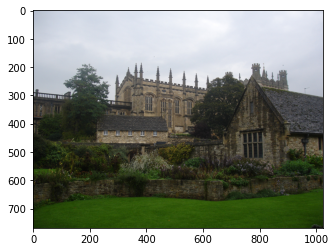

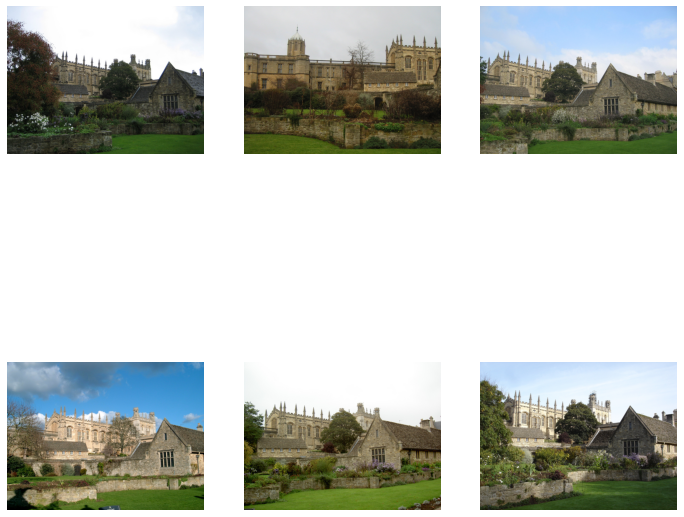

In [ ]:
query = Image.open(query_path) 
show_imgs(query, normal_ids)